# Das Bechdel test: Data and Methods

Lots of people have studied the effects of the Bechdel test on movies: in particular <a href="https://fivethirtyeight.com/tag/bechdel-test/">several articles on fivethirtyeight.com</a> and <a href="http://www.brianckeegan.com/2014/04/the-need-for-openness-in-data-journalism/">an article by Brian Keegan extending 538's work</a>. These are some notes from my own exploration of the topic. Maybe to be turned into a blog post or paper.

As I reminder, the Bechdel test is way of evaluating movie scripts on their representation of women. It says: "There are two women and they talk to each other about something other than a man." That seems like a ridiculously low bar, but still at least 40% of movies fail it.

## Getting the data

First, some preliminaries (importing needed Python packages). Then, load the data. Let's assume here that I did that data-ing correctly. See scripts numbered 1 through 6 to see how I got to this point. One thing to keep in mind is that whenever I quote budgets or profits, those have already been inflation-adjusted to be in Dec-2016 dollar values (that happens in script #6).

If you are looking at this through a Jupyter notebook interface, you can run the Code block below by clicking on it and pressing Shift-Enter. It should result in a message that says "Dataset loaded".

In [1]:
#from itertools import product
#from matplotlib.collections import LineCollection
#import statsmodels.formula.api as smf
import numpy as np
import scipy
from scipy.stats import linregress
from matplotlib import pyplot as plt
from IPython.display import Image, display, HTML
import pandas as pd
import datetime as datetime
import warnings
warnings.filterwarnings('ignore')
movies_df = pd.read_csv('movies_for_analysis.csv',encoding='utf-8',index_col='imdb_id')
movies_df['released'] = pd.to_datetime(movies_df['released'])
print('Dataset loaded')

Dataset loaded


## Choosing a study sample

Next question: which movies are we going to study? I grabbed a lot of movies in scripts #1-6, but they won't necessarily all be of interest to us. This is where we decide what is in and what is out.

### Whose movies?

The Bechdel test was invented to discuss Hollywood movies, which is a slightly vague and nebulous term. Ideally we would want to consider releases from "major Hollywood studios," but that is hard to define. This is because of the "Fox Searchlight problem." Fox Searchlight is a subsidiary of Fox that distributes foreign films. Should they be considered as a part of 20th Century Fox, or not?

Even if that were easy to define, it would still be hard to put into code, because there are so damn many studios represented. Run the code block below to see just how many.

In [2]:
display(HTML('<p>The number of unique studios in our dataset (remember, not yet cut on time), according to two sources:'))

#movies_df.columns
nStudiosIMDb = len(movies_df.groupby('studio'))  # studio data from IMDb
nStudiosBOM = len(movies_df.groupby('studio_boxofficemojo')) # studio data from boxofficemojo.com (as of May 2017)

print('Number of studios according to IMDb: {0:,.0f}'.format(nStudiosIMDb))
print('Number of studios according to Box Office Mojo: {0:,.0f}'.format(nStudiosBOM))
print('(Those lists certainly overlap)')

Number of studios according to IMDb: 1,374
Number of studios according to Box Office Mojo: 202
(Those lists certainly overlap)


So let's try a different approach that is certainly not perfect, but will get us closer to where we want to be: consider only movies made in the US (the value for "country" from OMDb includes 'usa').

In [3]:
#print('Number of movies before: {:,.0f}'.format(len(movies_df)))
movies_df = movies_df[movies_df['usa'] == 1]
print('Selected only movies made in the United States.')
#print('Number of movies after: {:,.0f}'.format(len(movies_df)))

Selected only movies made in the United States.


### Movies from when?

Assuming we have appropriately selected "Hollywood movies" as our object of study, "Hollywood" means something very different now than it did many years ago. We are interested mostly in the Hollywood of today, but we do also want to look back a bit to see if the situation has changed. Eliminating the very oldest movies will serve another purpose also: we know that our dataset is less complete for the earliest years, so this eliminates a possible source of bias.

So we want to look back into the past, but not too far into the past - but when exactly is our cutoff for which movies to include? I picked 1969, which was the first full year in which MPAA ratings had replaced the Hays Code. That seems like as good a place as any to draw a line between "Old Hollywood" and "Modern Hollywood."

If you'd like to draw that line at a different point instead, change the value of <code>firstyear</code> in the very first line of the Code block below, then rerun everything below that point.

In [4]:
firstyear = 1969
movies_df = movies_df[movies_df['bechdel_year'] >= firstyear]
print('Selected only movies released since {:.0f}.'.format(firstyear))

Selected only movies released since 1969.


Cool, so how many movies does that leave us with? And how many do we have complete data for?

Our dataset is such that every movie included has a Bechdel test result, but not every movie has financial data. Run the next Code block to see how many movies we are dealing with.

In [5]:
display(HTML('<h3>Number of movies in our study sample</h3>'.format(firstyear)))

print('Total number of movies: {:,.0f}'.format(len(movies_df)))
print('Movies with Bechdel test results: {:,.0f}'.format(len(movies_df[~pd.isnull(movies_df['bechdel_rating'])])))
print('')
print('Movies with box office receipt data: {:,.0f}'.format(len(movies_df[~pd.isnull(movies_df['boxoffice_adj'])])))
print('Movies with budget, profit, and ROI data: {:,.0f}'.format(len(movies_df[~pd.isnull(movies_df['profit_adj'])])))

Total number of movies: 4,252
Movies with Bechdel test results: 4,252

Movies with box office receipt data: 3,486
Movies with budget, profit, and ROI data: 2,409


It's hard to find sample sizes for either the 538 study or Keegan's study (I'll see if I can find them laters), I'm pretty sure ours is the largest study of this kind ever undertaken.

w00t!

## Whyfore art thou, Bechdel?
### (AKA are we using the right methodology to answer our questions?)

So now we know which movies are in for our study, and which are out. Next up: considering whether the Bechdel test is even a useful way to understand the representation of women in movies.

I have my doubts, and maybe we can come up with a better metric later &mdash; but for now, the Bechdel test seems like the only game in town, so let's roll with it.

Next question: how do we treat the Bechdel test? Because it's a three-part test, so you could easily imagine scoring it: zero points if there are one or zero women, one point if there are 2+ but they don't talk to each other, two points if they talk about a man, and three points for a full pass. I'll consider that in an appendix here. But I think it's more in line with the original purpose of the test to consider it as a hard pass/fail. That has another advantage: having only two (ordered) categories makes our analysis easier to undertake, interpret, and explain.

In [6]:
# Create a new variable called 'bechdel_passed': 1 for films that pass the test, 0 for films that fail.
movies_df['bechdel_passed'] = np.where(movies_df['bechdel_rating'] == 3, 1, 0)
display(HTML('<p>Created new variable with hard pass/fail Bechdel test results: <code>bechdel_passed</code>.</p>'))

Which movies pass or fail the Bechdel test? As I said, I'm not entirely sure the Bechdel test is the right metric for measuring the representation of <a href='https://www.youtube.com/watch?v=KCjMZMxNr-0'>women in film</a>.

Let's look at a few movies and apply some common sense check whether we think the Bechdel test is a legit way of looking at the representation of women (in stats lingo: testing for <em>face validity</em>). Run the code block below to see some movies that both fail and pass the Bechdel test. For both failures and passes, the code shows three randomly chosen movies followed by the five highest-grossing movies. They are displayed in a table. The last column of each table has a follow-able link to that movie's entry on the Bechdel test site, so you can see the text from the original submitter explaining why s/he scored that movie the way s/he did.

Run the Code block below. Read the four lists of movies and ask yourself (to put it somewhat necessarily bluntly): Do I buy it?

In [7]:
display(HTML('<h3>Movies that fail the Bechdel test</h3>'))

display(HTML('<h4>Three randomly-chosen movies that fail the Bechdel test:</h4>'))
random_failers = movies_df.dropna()[['title','bechdel_year','boxoffice_adj','bechdel_site_id']][movies_df['bechdel_passed'] == 0].sample(3).sort_values(['bechdel_year','title']).values.tolist()

# Surely there is an easier way to print a pandas dataframe as a well-formatted table?
#### Maybe by sending a dictionary of styles to .style.format()? Halp?
#### But anyway, this kinda-hacky code does what needs doing.
y = '<table>'
y += '<tr>'
y += '<th>Title</th>'
y += '<th>Year</th>'
y += '<th>Box office (Dec-2016 $)</th>'
y += '<th>Link</th>'
y += '</tr>'
for row in random_failers:
    link = 'http://www.bechdeltest.com/view/'+str(row[3])
    link_str = '<a href=\''+link+'\' target="_blank">'+link+'</a>'
    y += '<tr>'
    y += '<td>{:}</td>'.format(row[0])
    y += '<td>{:.0f}</td>'.format(row[1])
    y += '<td style="text-align:right">${:,.0f}</td>'.format(row[2])
    y += '<td>{:}</td>'.format(link_str)
    y += '</tr>'
y += '</table>'
display(HTML(y))

display(HTML('<h4>The five highest-grossing movies that fail the Bechdel test:</h2>'))
highest_failers = movies_df[['title','bechdel_year','boxoffice_adj','bechdel_site_id']][movies_df['bechdel_passed'] == 0].sort_values('boxoffice_adj',ascending=False).head(5).values.tolist()

y = '<table>'
y += '<tr>'
y += '<th>Title</th>'
y += '<th>Year</th>'
y += '<th>Box office (Dec-2016 $)</th>'
y += '<th>Link</th>'
y += '</tr>'
for row in highest_failers:
    link = 'http://www.bechdeltest.com/view/'+str(row[3])
    link_str = '<a href=\''+link+'\' target="_blank">'+link+'</a>'
    y += '<tr>'
    y += '<td>{:}</td>'.format(row[0])
    y += '<td>{:.0f}</td>'.format(row[1])
    y += '<td style="text-align:right">${:,.0f}</td>'.format(row[2])
    y += '<td>{:}</td>'.format(link_str)
    y += '</tr>'
y += '</table>'
display(HTML(y))

display(HTML('<h3>Movies that pass the Bechdel test</h3>'))

display(HTML('<h4>Three randomly-chosen movies that pass the Bechdel test:</h4>'))
random_passers = movies_df.dropna()[['title','bechdel_year','boxoffice_adj','bechdel_site_id']][movies_df['bechdel_passed'] == 1].sample(3).sort_values(['bechdel_year','title']).values.tolist()

# Surely there is an easier way to print a pandas dataframe as a well-formatted table?
#### Maybe by sending a dictionary of styles to .style.format()? Halp?
#### But anyway, this kinda-hacky code does what needs doing.
y = '<table>'
y += '<tr>'
y += '<th>Title</th>'
y += '<th>Year</th>'
y += '<th>Box office (Dec-2016 $)</th>'
y += '<th>Link</th>'
y += '</tr>'
for row in random_passers:
    link = 'http://www.bechdeltest.com/view/'+str(row[3])
    link_str = '<a href=\''+link+'\' target="_blank">'+link+'</a>'
    y += '<tr>'
    y += '<td>{:}</td>'.format(row[0])
    y += '<td>{:.0f}</td>'.format(row[1])
    y += '<td style="text-align:right">${:,.0f}</td>'.format(row[2])
    y += '<td>{:}</td>'.format(link_str)
    y += '</tr>'
y += '</table>'
display(HTML(y))

display(HTML('<h4>The five highest-grossing movies that pass the Bechdel test:</h2>'))
highest_passers = movies_df[['title','bechdel_year','boxoffice_adj','bechdel_site_id']][movies_df['bechdel_passed'] == 1].sort_values('boxoffice_adj',ascending=False).head(5).values.tolist()

y = '<table>'
y += '<tr>'
y += '<th>Title</th>'
y += '<th>Year</th>'
y += '<th>Box office (Dec-2016 $)</th>'
y += '<th>Link</th>'
y += '</tr>'
for row in highest_passers:
    link = 'http://www.bechdeltest.com/view/'+str(row[3])
    link_str = '<a href=\''+link+'\' target="_blank">'+link+'</a>'
    y += '<tr>'
    y += '<td>{:}</td>'.format(row[0])
    y += '<td>{:.0f}</td>'.format(row[1])
    y += '<td style="text-align:right">${:,.0f}</td>'.format(row[2])
    y += '<td>{:}</td>'.format(link_str)
    y += '</tr>'
y += '</table>'
display(HTML(y))

Title,Year,Box office (Dec-2016 $),Link
Holes,2003,"$88,512,707",http://www.bechdeltest.com/view/1136
"Italian Job, The",2003,"$139,630,601",http://www.bechdeltest.com/view/48
"Grand Budapest Hotel, The",2014,"$60,360,829",http://www.bechdeltest.com/view/5229


Title,Year,Box office (Dec-2016 $),Link
Star Wars,1977,"$1,845,765,685",http://www.bechdeltest.com/view/669
Star Wars: Episode V - The Empire Strikes Back,1980,"$856,735,206",http://www.bechdeltest.com/view/670
Avatar,2009,"$850,251,110",http://www.bechdeltest.com/view/582
"Sting, The",1973,"$834,123,140",http://www.bechdeltest.com/view/2316
"Godfather, The",1972,"$787,082,380",http://www.bechdeltest.com/view/2224


Title,Year,Box office (Dec-2016 $),Link
Hard Candy,2005,"$1,227,697",http://www.bechdeltest.com/view/415
"Hundred-Foot Journey, The",2014,"$55,051,759",http://www.bechdeltest.com/view/5692
No Good Deed,2014,"$53,294,378",http://www.bechdeltest.com/view/5813


Title,Year,Box office (Dec-2016 $),Link
Jaws,1975,"$1,171,125,373",http://www.bechdeltest.com/view/2561
E.T.: The Extra-Terrestrial,1982,"$1,082,985,683",http://www.bechdeltest.com/view/1645
"Exorcist, The",1973,"$1,057,426,936",http://www.bechdeltest.com/view/751
Titanic,1997,"$985,893,188",http://www.bechdeltest.com/view/345
Star Wars: The Force Awakens,2015,"$956,094,427",http://www.bechdeltest.com/view/6610


### Is the list of movies on bechdeltest.com representative of all movies?

tl;dr: NO.

If have a representative sample, then every movie in the population (all Hollywood movies) has an equal chance of appearing in the sample (the movies listed on bechdeltest.com). If not, then there is some factor or factors that make the movies on the list different from all movies overall. One possibility is that people who submit movies to bechdeltest.com are more likely to notice and submit movies that pass the Bechdel test, so that the percentage of passes in our dataset is greater than the percentage of passes in all movies. Or it could go the other way - people are more likely to notice and report movies that fail.

Lots of people have wondered about the representativeness of movies on bechdeltest.com, but AFAIK no one has examined this question empirically. We can't either with the data we have now - but if we start with a complete list of movies from IMDb then join the bechdeltest.com list to it, we maybe can address this question. I'll address it ma&ntilde;ana.

This is not a problem as long as we don't generalize beyond our scope. When we state our conclusions, we must be careful to restrict our statements to being about "movies reported on bechdeltest.com" and not just "movies." Watch for that in the writeup.

# Das Bechdel Test: Results

Yay, now we are in a position to explore for results!

## How many movies pass the Bechdel test?

First-order question: what percentage of movies in our sample pass and fail the Bechdel test?

In [8]:
hollywood_string = ''
if (int(movies_df['usa'][movies_df['usa'] == 0].size) == 0):
    hollywood_string = 'US-made '
display(HTML('<h3>Bechel test pass/fail results for {0:} movies released since {1:.0f} (n = {2:,.0f})</h3>'.format(hollywood_string,firstyear,len(movies_df))))
bechdel_result_table = pd.DataFrame()
bechdel_result_table['nMovies'] = movies_df.groupby('bechdel_passed').size()
bechdel_result_table['result'] = ''
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 0, 'Fail',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 1, 'Pass',bechdel_result_table['result'])
bechdel_result_table['percentage'] = 100 * (bechdel_result_table['nMovies'] / len(movies_df))

# I made this table again but only with movies that have profit data - percentages are identical: 41% fail, 59% pass
#bechdel_result_table['nMovies'] = movies_df[~pd.isnull(movies_df['profit_adj'])].groupby('bechdel_rating').size()

bechdel_result_table[['result','nMovies','percentage']].style.format({'result': '{:10}', 'nMovies': '{:,.0f}', 'percentage': '{0:.0f}%'})

,result,nMovies,percentage
bechdel_passed,,,
0,Fail,"1,745",41%
1,Pass,"2,507",59%


## Bechdel test results over time

Now, we're getting to The Interesting Part (note Winnie-the-Pooh Capitals). Have the results changed over time? If we accept that the Bechdel test is an accurate measure of the representation of women in movies (maybe it isn't, but it's the only game in town for quantiative research into this question), then this is a way of asking: has Hollywood's depiction of women in movies changed over the years? Of course, this change could be positive or negative, but we would hope and expect Bechdel test scores to increase with time.

Since the Bechdel test for us is a pass/fail (fail = 0, pass = 1), then asking what is the average score in a given year is the same as asking what percentage of films pass the test in that year. That's what the blue line in the graph below shows. The x-axis shows the year and the y-axis shows the percentage of US-made films released in that year that pass the Bechdel test. Error bars are standard error of the mean (stdev/n); note that they are larger in earlier years, when there are fewer movies in the dataset. The red line is explained below the graph.

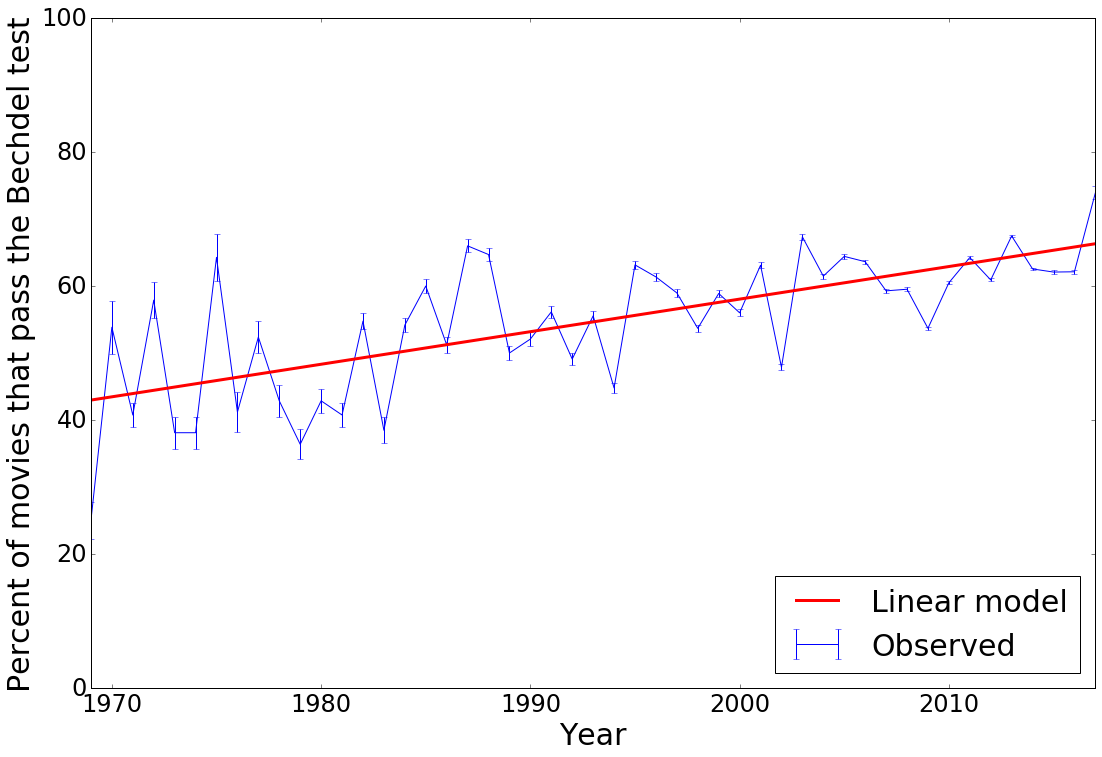

Each year since 1969, an additional 0.49% of movies pass the Bechdel test (r^2 = 0.46; p = 0.00000007).
At this rate of increase, all movies will pass the Bechdel test in the year 2087.


In [22]:
#firstyear = 1969 # first year after the Hays code ended
lastyear = 2017 # last full year in dataset
avg_bechdel = movies_df.groupby('bechdel_year')['bechdel_passed'].agg(np.mean)
avg_bechdel.index.name = 'date'
avg_bechdel.name = 'bechdel'
avg_bechdel = avg_bechdel[(avg_bechdel.index >= firstyear) & (avg_bechdel.index <= lastyear)]
avg_bechdel = avg_bechdel.reset_index()
#avg_bechdel

stdevm_bechdel = movies_df.groupby('bechdel_year')['bechdel_passed'].agg(np.std) / movies_df.groupby('bechdel_year')['bechdel_passed'].size()
stdevm_bechdel.index.name = 'date'
stdevm_bechdel.name = 'bechdel'
stdevm_bechdel = stdevm_bechdel[(stdevm_bechdel.index >= firstyear) & (stdevm_bechdel.index <= lastyear)]
stdevm_bechdel = stdevm_bechdel.reset_index()

# multiply both by 100 to express as percentage
avg_bechdel['bechdel'] = avg_bechdel['bechdel'] * 100
stdevm_bechdel['bechdel'] = stdevm_bechdel['bechdel'] * 100

[slope,intercept,rvalue,pvalue,stderr] = linregress(avg_bechdel['date'],avg_bechdel['bechdel'])
#print(slope,intercept,rvalue)
r_squared = rvalue ** 2

predicted = pd.DataFrame({"date": np.linspace(start=1969.,stop=2969.,num=1001)})
predicted['bechdel'] = slope*predicted['date'] + intercept

# Plot the observed data
fig = plt.figure(figsize=(18,12))
plt.errorbar(avg_bechdel['date'],avg_bechdel['bechdel'],yerr=stdevm_bechdel['bechdel'],c='b',label='Observed')
# Plot the predictions from the model
plt.plot(predicted['date'],predicted['bechdel'],c='r',label='Linear model',lw=3)
plt.legend(loc='lower right', fontsize=30)
plt.ylim((0,100))
plt.xlim((1969,2017))
plt.xlabel('Year', fontsize=30)
plt.ylabel('Percent of movies that pass the Bechdel test', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=24)
#fig.show()
plt.show()
everything_passes_year = predicted['date'].loc[predicted['bechdel'] >= 100].agg(np.min)

print('Each year since {0:.0f}, an additional {1:.2f}% of movies pass the Bechdel test (r^2 = {2:.2f}; p = {3:.8f}).'.format(firstyear,slope,r_squared,pvalue))
print('At this rate of increase, all movies will pass the Bechdel test in the year {0:.0f}.'.format(everything_passes_year))

display(HTML('<p><b><font color="red">TODO</font></b>: fit data to a flat model, compare, calculate likelihood ratio.</p>'))

The red line is a best-fit statistical model assuming that Bechdel teset scores change linearly with time.

The model is described in words below the graph. Each year from 1969 to 2017, an additional 0.49% of movies pass the test. The numbers in parentheses are measures of the degree to which the simple model matches the real-life data. The most important number is r<sup>2</sup>, which varies from 0 to 1. The standards for what r<sup>2</sup> value are "good enough" to draw conclusions vary by field and are up to the writer to propose and the reader to evaluate. In this research, r<sup>2</sup> = 0.46 probably counts as a weak effect. It's not compelling, but it's suggestive that Bechdel test scores probably are increasing slowly over time.

## Bechdel results and budgets

The next question - again, one that both fivethirtyeight and Keegan have looked at - is whether there is any relationship between a film's budget and its Bechdel test results. To do that, let's divide our data into two groups: those that fail the Bechdel test and those that pass. Then let's make a histogram that shows how many small-budget vs. big-budget movies are in each category. We don't make any assumptions about what a "small" or "big budget" is, let's just look at the data.

In [10]:
display(HTML('<h3>Budgets of {0:} movies released since {1:.0f} that pass or fail the Bechdel test (n = {2:,.0f})</h3>'.format(hollywood_string,firstyear,len(movies_df))))


#x = movies_df['bechdel_passed'].apply(lambda x:float(x)+np.random.normal(0, 0.05))
#y = movies_df['budget_adj']
failer_budgets = movies_df.dropna()['budget_adj'][movies_df['bechdel_passed'] == 0]
passer_budgets = movies_df.dropna()['budget_adj'][movies_df['bechdel_passed'] == 1]
#plt.hist(failer_budgets,bins=30)

# Calculate best bin widths by Freedman-Draconis rule.
#The bin-width is set to h = 2 * IQR * n^(−1/3).
#So the number of bins is (max−min)/h.

fail_n = len(failer_budgets)
fail_iqr = scipy.stats.iqr(failer_budgets)
fail_binwidth = 2 * fail_iqr * (fail_n ** (-1/3))
fail_bins = (np.max(failer_budgets) - np.min(failer_budgets)) / fail_binwidth

pass_n = len(passer_budgets)
pass_iqr = scipy.stats.iqr(passer_budgets)
pass_binwidth = 2 * pass_iqr * (pass_n ** (-1/3))
pass_bins = (np.max(passer_budgets) - np.min(passer_budgets)) / pass_binwidth

nbins = int(np.round(np.mean([fail_bins,pass_bins]),0))
#print(nbins)

fig = plt.figure(figsize=(18,18))

ax1 = fig.add_subplot(221)
ax1.hist(failer_budgets,bins=nbins,range=(0,500000000))
plt.ylim([0,300])
plt.xlabel('Budget (Dec-2016$)')
plt.ylabel('Number of movies')
plt.title('Fail')

ax2 = fig.add_subplot(222)
ax2.hist(passer_budgets,bins=nbins,range=(0,500000000))
plt.ylim([0,300])
plt.xlabel('Budget (million Dec-2016$)')
plt.ylabel('Number of movies')
plt.title('Pass')

fig.show()


AttributeError: module 'scipy.stats' has no attribute 'iqr'

In [11]:
display(HTML('<p>Movie budgets vary widely.</p>'))
movies_df[['title','bechdel_year','budget','budget_adj']].sort_values('budget_adj',ascending=True).head(5)  # five lowest budgets
#movies_df[['title','bechdel_year','budget','budget_adj']].sort_values('budget_adj',ascending=False).head(5) # five highest budgets

lowest_budget_movie = movies_df.sort_values('budget_adj')['title'].iloc[0]
lowest_budget_year = movies_df.sort_values('budget_adj')['bechdel_year'].iloc[0]
lowest_budget_budget_raw = movies_df.sort_values('budget_adj')['budget'].iloc[0]
lowest_budget_budget_adj = movies_df.sort_values('budget_adj')['budget_adj'].iloc[0]

print('For example:')
print('{0:} was made for ${1:,.0f} in {2:.0f} (${3:,.0f} Dec-2016-adjusted).'.format(lowest_budget_movie,lowest_budget_budget_raw,lowest_budget_year,lowest_budget_budget_adj))
print('...while...')

highest_budget_movie = movies_df.sort_values('budget_adj',ascending=False)['title'].iloc[0]
highest_budget_year = movies_df.sort_values('budget_adj',ascending=False)['bechdel_year'].iloc[0]
highest_budget_budget_raw = movies_df.sort_values('budget_adj',ascending=False)['budget'].iloc[0]
highest_budget_budget_adj = movies_df.sort_values('budget_adj',ascending=False)['budget_adj'].iloc[0]

print('{0:} was made for ${1:,.0f} in {2:.0f} (${3:,.0f} Dec-2016-adjusted).'.format(highest_budget_movie,highest_budget_budget_raw,highest_budget_year,highest_budget_budget_adj))

For example:
Primer was made for $7,000 in 2004 ($8,853 Dec-2016-adjusted).
...while...
Avatar was made for $425,000,000 in 2009 ($475,152,003 Dec-2016-adjusted).


When faced with data that covers such a wide range, sometimes it helps to plot the data on a logarithmic scale:

In [12]:
fig = plt.figure(figsize=(12,12))

failer_budgets_logged = np.log10(failer_budgets)
passer_budgets_logged = np.log10(passer_budgets)

faillog_n = len(failer_budgets_logged)
faillog_iqr = scipy.stats.iqr(failer_budgets_logged)
faillog_binwidth = 2 * faillog_iqr * (faillog_n ** (-1/3))
faillog_bins = (np.max(failer_budgets_logged) - np.min(failer_budgets_logged)) / faillog_binwidth

passlog_n = len(passer_budgets_logged)
passlog_iqr = scipy.stats.iqr(passer_budgets_logged)
passlog_binwidth = 2 * passlog_iqr * (passlog_n ** (-1/3))
passlog_bins = (np.max(passer_budgets_logged) - np.min(passer_budgets_logged)) / faillog_binwidth

nbins = int(np.round(np.mean([faillog_bins,passlog_bins]),0))

ax1 = fig.add_subplot(221)
ax1.hist(failer_budgets_logged,bins=nbins)#,range=(0.1,9))
plt.xlim([4,9])
plt.ylim([0,100])
plt.xlabel('Budget (Dec-2016$): LOG SCALE')
plt.ylabel('Number of movies')
plt.title('Fail')

ax2 = fig.add_subplot(222)
ax2.hist(passer_budgets_logged,bins=nbins)#,range=(0,500000000))
plt.xlim([4,9])
plt.ylim([0,100])
plt.xlabel('Budget (million Dec-2016$): LOG SCALE')
plt.ylabel('Number of movies')
plt.title('Pass')

fig.show()


AttributeError: module 'scipy.stats' has no attribute 'iqr'

The log-scale graph helps us see that there is definitely some difference in budgets between the two groups, although it's hard to tell at a glance what that difference is.

The best way to test for differences in data with such wide variation is to look for differences in the median. Finding the median budget in each group means let's line up all the budget values from lowest to highest and picking the one in the middle.

What are the median budgets of movies that fail and pass the Bechdel test? Which value is higher, and by how much?

In [ ]:
failer_n = len(failer_budgets)
passer_n = len(passer_budgets)

failer_median_budget = failer_budgets.agg(np.median)
passer_median_budget = passer_budgets.agg(np.median)

print('Movies that fail the Bechdel test have a median budget of ${0:,.0f} (n={1:.0f}).'.format(failer_median_budget, failer_n))
print('Movies that pass the Bechdel test have a median budget of ${0:,.0f} (n={1:.0f}).'.format(passer_median_budget, passer_n))

median_difference = passer_median_budget - failer_median_budget
direction_string = '<b>'
if (median_difference < 0):
    direction_string += 'lower than'
elif (median_difference > 0):
    direction_string += 'higher than'
else:
    direction_string += 'equal to'
direction_string += '</b>'
median_difference = abs(median_difference)

display(HTML('<p>Movies that pass the Bechdel test have a median budget ${0:,.0f} {1:} those that fail.</p>.'.format(median_difference,direction_string)))

Is that difference in median budget statistically significant? That question calls for a Mann-Whitney U test.

In [ ]:
display(HTML('<p>Is the difference in median budgets statistically significant?</p>'))
[ustat, pvalue] = scipy.stats.mannwhitneyu(failer_budgets, passer_budgets, use_continuity=True, alternative='two-sided')

if (pvalue < .05):
    print('YES')
else:
    print('NO')

print('p-value: ',pvalue)

display(HTML('<p><b><font color="red">TODO:</font></b> Calculate effect size also!</h1>'))

# EVERYTHING BELOW HERE IS WORK IN PROGRESS

# PROFITS

Now what about profit?

In [ ]:
failer_profits = movies_df.dropna()['profit_adj'][movies_df['bechdel_passed'] == 0]
passer_profits = movies_df.dropna()['profit_adj'][movies_df['bechdel_passed'] == 1]

#print('Median profit of films that fail the Bechdel test: ${0:,.0f}.'.format(failer_budgets.agg(np.median)))
#print('Median budget of films that pass the Bechdel test: ${0:,.0f}.'.format(passer_budgets.agg(np.median)))

# Calculate best bin widths by Freedman-Draconis rule.
#The bin-width is set to h = 2 * IQR * n^(−1/3).
#So the number of bins is (max−min)/h.

fail_n = len(failer_profits)
fail_iqr = scipy.stats.iqr(failer_profits)
fail_binwidth = 2 * fail_iqr * (fail_n ** (-1/3))
fail_bins = (np.max(failer_profits) - np.min(failer_profits)) / fail_binwidth
#print(fail_bins)

pass_n = len(passer_profits)
pass_iqr = scipy.stats.iqr(passer_profits)
pass_binwidth = 2 * fail_iqr * (fail_n ** (-1/3))
pass_bins = (np.max(passer_profits) - np.min(passer_profits)) / pass_binwidth
#print(pass_bins)
nbins = int(np.round(np.mean([fail_bins,pass_bins]),0))
#print(nbins)

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(221)
ax1.hist(failer_profits,bins=nbins)#,range=(-30000000,1000000000))
plt.ylim([0,35])
plt.xlabel('Profit (Dec-2016$)')
plt.ylabel('Number of movies')
plt.title('Fail')

ax2 = fig.add_subplot(222)
ax2.hist(passer_profits,bins=nbins)#,range=(-30000000,1000000000))
plt.ylim([0,35])
plt.xlabel('Profit (million Dec-2016$)')
plt.ylabel('Number of movies')
plt.title('Pass')
print('Min: {0:,.0f} Max: {1:,.0f}'.format(np.min(failer_profits),np.max(failer_profits)))
print('Min: {0:,.0f} Max: {1:,.0f}'.format(np.min(passer_profits),np.max(passer_profits)))
#fig.show()
z  = movies_df[['title','bechdel_year','budget_adj','boxoffice_adj','profit_adj']][movies_df['title'] == 'Star Wars'].values.tolist()

# Below here, I consider "partial pass" results also

In [ ]:
display(HTML('<h2>Total movies with Bechel test results</h2>'))
bechdel_result_table = pd.DataFrame()
bechdel_result_table['nMovies'] = movies_df.groupby('bechdel_rating').size()
bechdel_result_table['result'] = ''
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 0, 'Fewer than two women',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 1, 'Women don\'t talk',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 2, 'Women talk about a man',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 3, 'Passes Bechdel test',bechdel_result_table['result'])
bechdel_result_table['percentage'] = 100 * (bechdel_result_table['nMovies'] / len(movies_df))
bechdel_result_table[['result','nMovies','percentage']].style.format({'result': '{:10}', 'nMovies': '{:,.0f}', 'percentage': '{0:.0f}%'})
# I made this table again but only with movies that have profit data - percentages are identical.
#bechdel_result_table2['nMovies'] = movies_df[~pd.isnull(movies_df['profit_adj'])].groupby('bechdel_rating').size()

We can also estimate a statistical model to forecast future changes in the average Bechdel score over time. We observe a general upward trend in movies passing more of the Bechdel test and can try to extrapolate this going forward.

In [ ]:
#import statsmodels.formula.api as smf
#from scipy import ols
firstyear = 1969 # first year after the Hays code ended
lastyear = 2016 # last full year in dataset
avg_bechdel = movies_df.groupby('bechdel_year')['bechdel_rating'].agg(np.mean)
avg_bechdel.index.name = 'date'
avg_bechdel.name = 'bechdel'
avg_bechdel = avg_bechdel[(avg_bechdel.index >= firstyear) & (avg_bechdel.index <= lastyear)]
avg_bechdel = avg_bechdel.reset_index()
#avg_bechdel

stdevm_bechdel = movies_df.groupby('bechdel_year')['bechdel_rating'].agg(np.std) / movies_df.groupby('bechdel_year')['bechdel_rating'].size()
stdevm_bechdel = stdevm_bechdel[(stdevm_bechdel.index >= firstyear) & (stdevm_bechdel.index <= lastyear)]

errorbarsy = stdevm_bechdel.get_values()

[slope,intercept,rvalue,pvalue,stderr] = linregress(avg_bechdel['date'],avg_bechdel['bechdel'])
#print(slope,intercept,rvalue)
r_squared = rvalue ** 2

print('Regression model: Bechdel test scores have increased by {0:.3f} each year since {1:.0f}, with r^2 = {2:.2f}.'.format(slope,firstyear,r_squared))
predicted = pd.DataFrame({"date": np.linspace(start=1969.,stop=2016.,num=48)})
predicted['bechdel'] = slope*predicted['date'] + intercept

# Plot the observed data
plt.errorbar(avg_bechdel['date'],avg_bechdel['bechdel'],yerr=errorbarsy,c='b',label='Observed')
# Plot the predictions from the model
plt.plot(predicted['date'],predicted['bechdel'],c='r',label='Linear model',lw=3)
plt.legend(loc='lower right')
plt.ylim((0,3))
plt.xlim((1969,2016))
plt.xlabel('Year')
plt.ylabel('Avg. Bechdel Test')
plt.show()

In [ ]:
movies_df['bechdel_passed'] = np.where((movies_df['bechdel_rating'] == 3), 1, 0)

display(HTML('<h2>Total movies with Bechel test pass/fail results</h2>'))
bechdel_result_table = pd.DataFrame()
bechdel_result_table['nMovies'] = movies_df.groupby('bechdel_passed').size()
bechdel_result_table['result'] = ''
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 0, 'Fail',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 1, 'Pass',bechdel_result_table['result'])
bechdel_result_table['percentage'] = 100 * (bechdel_result_table['nMovies'] / len(movies_df))
bechdel_result_table[['result','nMovies','percentage']].style.format({'result': '{:10}', 'nMovies': '{:,.0f}', 'percentage': '{0:.0f}%'})
# I made this table again but only with movies that have profit data - percentages are identical.
#bechdel_result_table2['nMovies'] = movies_df[~pd.isnull(movies_df['profit_adj'])].groupby('bechdel_rating').size()

In [ ]:
#import statsmodels.formula.api as smf
#from scipy import ols
firstyear = 1969 # first year after the Hays code ended
lastyear = 2016 # last full year in dataset
avg_bechdel = movies_df.groupby('bechdel_year')['bechdel_passed'].agg(np.mean)
avg_bechdel.index.name = 'date'
avg_bechdel.name = 'bechdel'
avg_bechdel = avg_bechdel[(avg_bechdel.index >= firstyear) & (avg_bechdel.index <= lastyear)]
avg_bechdel = avg_bechdel.reset_index()
#avg_bechdel

stdevm_bechdel = movies_df.groupby('bechdel_year')['bechdel_passed'].agg(np.std) / movies_df.groupby('bechdel_year')['bechdel_passed'].size()
stdevm_bechdel.index.name = 'date'
stdevm_bechdel.name = 'bechdel'
stdevm_bechdel = stdevm_bechdel[(stdevm_bechdel.index >= firstyear) & (stdevm_bechdel.index <= lastyear)]
stdevm_bechdel = stdevm_bechdel.reset_index()

# multiply both by 100 to express as percentage
avg_bechdel['bechdel'] = avg_bechdel['bechdel'] * 100
#stdevm_bechdel['bechdel'] = stdevm_bechdel['bechdel'] * 100

#errorbarsy = stdevm_bechdel.get_values()

[slope,intercept,rvalue,pvalue,stderr] = linregress(avg_bechdel['date'],avg_bechdel['bechdel'])
#print(slope,intercept,rvalue)
r_squared = rvalue ** 2

print('Regression model: Each year since {0:.0f}, an additional {1:.2f}% of movies pass the Bechdel test (r^2 = {2:.2f}).'.format(firstyear,slope,r_squared))

predicted = pd.DataFrame({"date": np.linspace(start=1969.,stop=2969.,num=1001)})
predicted['bechdel'] = slope*predicted['date'] + intercept

# Plot the observed data
plt.errorbar(avg_bechdel['date'],avg_bechdel['bechdel'],yerr=stdevm_bechdel['bechdel'],c='b',label='Observed')
# Plot the predictions from the model
plt.plot(predicted['date'],predicted['bechdel'],c='r',label='Linear model',lw=3)
plt.legend(loc='lower right')
plt.ylim((0,100))
plt.xlim((1969,2016))
plt.xlabel('Year')
plt.ylabel('Percent of movies that pass the Bechdel test')
plt.show()
everything_passes_year = predicted['date'].loc[predicted['bechdel'] >= 100].agg(np.min)
print('At this rate of increase, all movies will pass the Bechdel test in the year {0:.0f}.'.format(everything_passes_year))

As I discussed above, the claim that budgets for Bechdel-passing movies is relatively uncontroversial and given the description of the data in the article, should be easy to reproduce. Visualizing the distribution of the data, there are no strong differences that jump out but if you squint hard enough, you can make out a negative trend: movies passing the Bechdel test have lower budgets.

You'll notice each cloud of points around 0, 1, 2, and 3. These are simply "jittered" by adding a bit of normally-distributed errors to the plots (but not the underlying data we're estimating) to show the frequency of datapoints without them all sitting on top of each other.

In [ ]:
x = movies_df['bechdel_rating'].apply(lambda x:float(x)+np.random.normal(0, 0.05))
y = movies_df['budget_adj']

# Plot with an alpha so the overlaps reveal something about relative density
plt.scatter(x,y,alpha=.2,label='Data',c='g')
plt.ylabel('Budgets (Dec-2016 $)',fontsize=18)
plt.xlabel('Bechdel dimensions',fontsize=18)
plt.xticks(np.arange(0,4))
plt.yscale('log')
plt.grid(False,which='minor')
#plt.ylim((2e0,1e10))

We can also visualize the median budgets with a bar chart to see that movies featuring two women who don't talk to each other appear to have much larger budgets than the rest. Movies that pass the Bechdel test also appear to have slightly smaller budgets than movies that don't pass.

In [ ]:
print(groupby)
movies_df['budget_adj'].groupby(movies_df['bechdel_rating']).agg(np.median).plot(kind='barh')
#plt.xticks(range(0,7e7,1e7),range(0,70,10),fontsize=15)
#plt.xticks(range(0e7,7e7,1e7),range(0,70,10),fontsize=15)
plt.xticks(range(0,60000000,10000000),range(0,60,10),fontsize=15)
plt.yticks(plt.yticks()[0],["Fewer than two women",
                             "Women don't talk to each other",
                             'Women only talk about men',
                             'Passes Bechdel Test'
                             ],fontsize=18)
plt.xlabel('Budget (Dec-2016 $millions)',fontsize=18)
plt.title('Median Budget for Films',fontsize=24)
plt.ylabel('')
plt.show()